In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import secondary_fyncions as sf
import xgboost as xgb
import lightgbm as lgb
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [80]:
def plot_loss(model, X_test, y_test):
    test_score = np.empty(len(model.estimators_))
    for i, pred in enumerate(model.staged_predict(X_test)):
        test_score[i] = model.loss_(y_test, pred)
    plt.plot(np.arange(len(model.estimators_)) + 1, test_score, label='Test')
    plt.plot(np.arange(len(model.estimators_)) + 1, model.train_score_, label='Train')
    plt.legend()

In [10]:
# Датасет https://www.kaggle.com/itsmesunil/bank-loan-modelling
data = pd.read_csv('Bank_Personal_Loan_Modelling.csv', index_col=0)
data.drop(labels=['ZIP Code'], axis=1, inplace=True)

In [11]:
data.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,
1,25,1,49,4,1.6,1,0,0,1,0,0,0
2,45,19,34,3,1.5,1,0,0,1,0,0,0
3,39,15,11,1,1.0,1,0,0,0,0,0,0
4,35,9,100,1,2.7,2,0,0,0,0,0,0
5,35,8,45,4,1.0,2,0,0,0,0,0,1


In [5]:
data.isnull().sum()

Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [6]:
data.describe()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


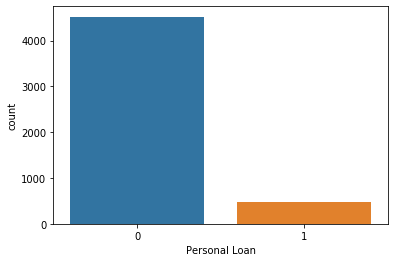

In [12]:
sns.countplot(x='Personal Loan',data=data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71884b19e8>,
      dtype=object)

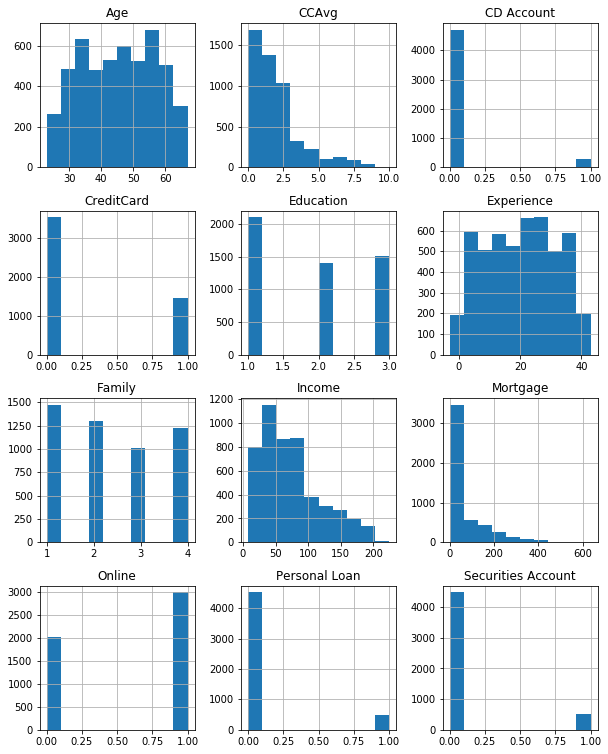

In [14]:
data.hist(figsize=(10,13))

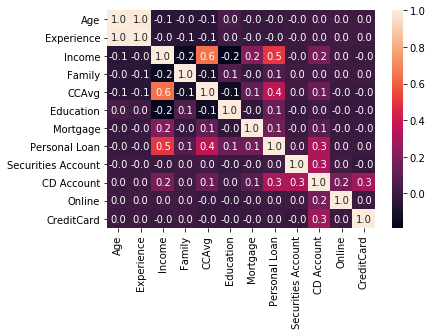

In [15]:
sns.heatmap(data.corr(), annot=True, fmt='.1f')

/home/tay/ml-2019-08/venv/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/tay/ml-2019-08/venv/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


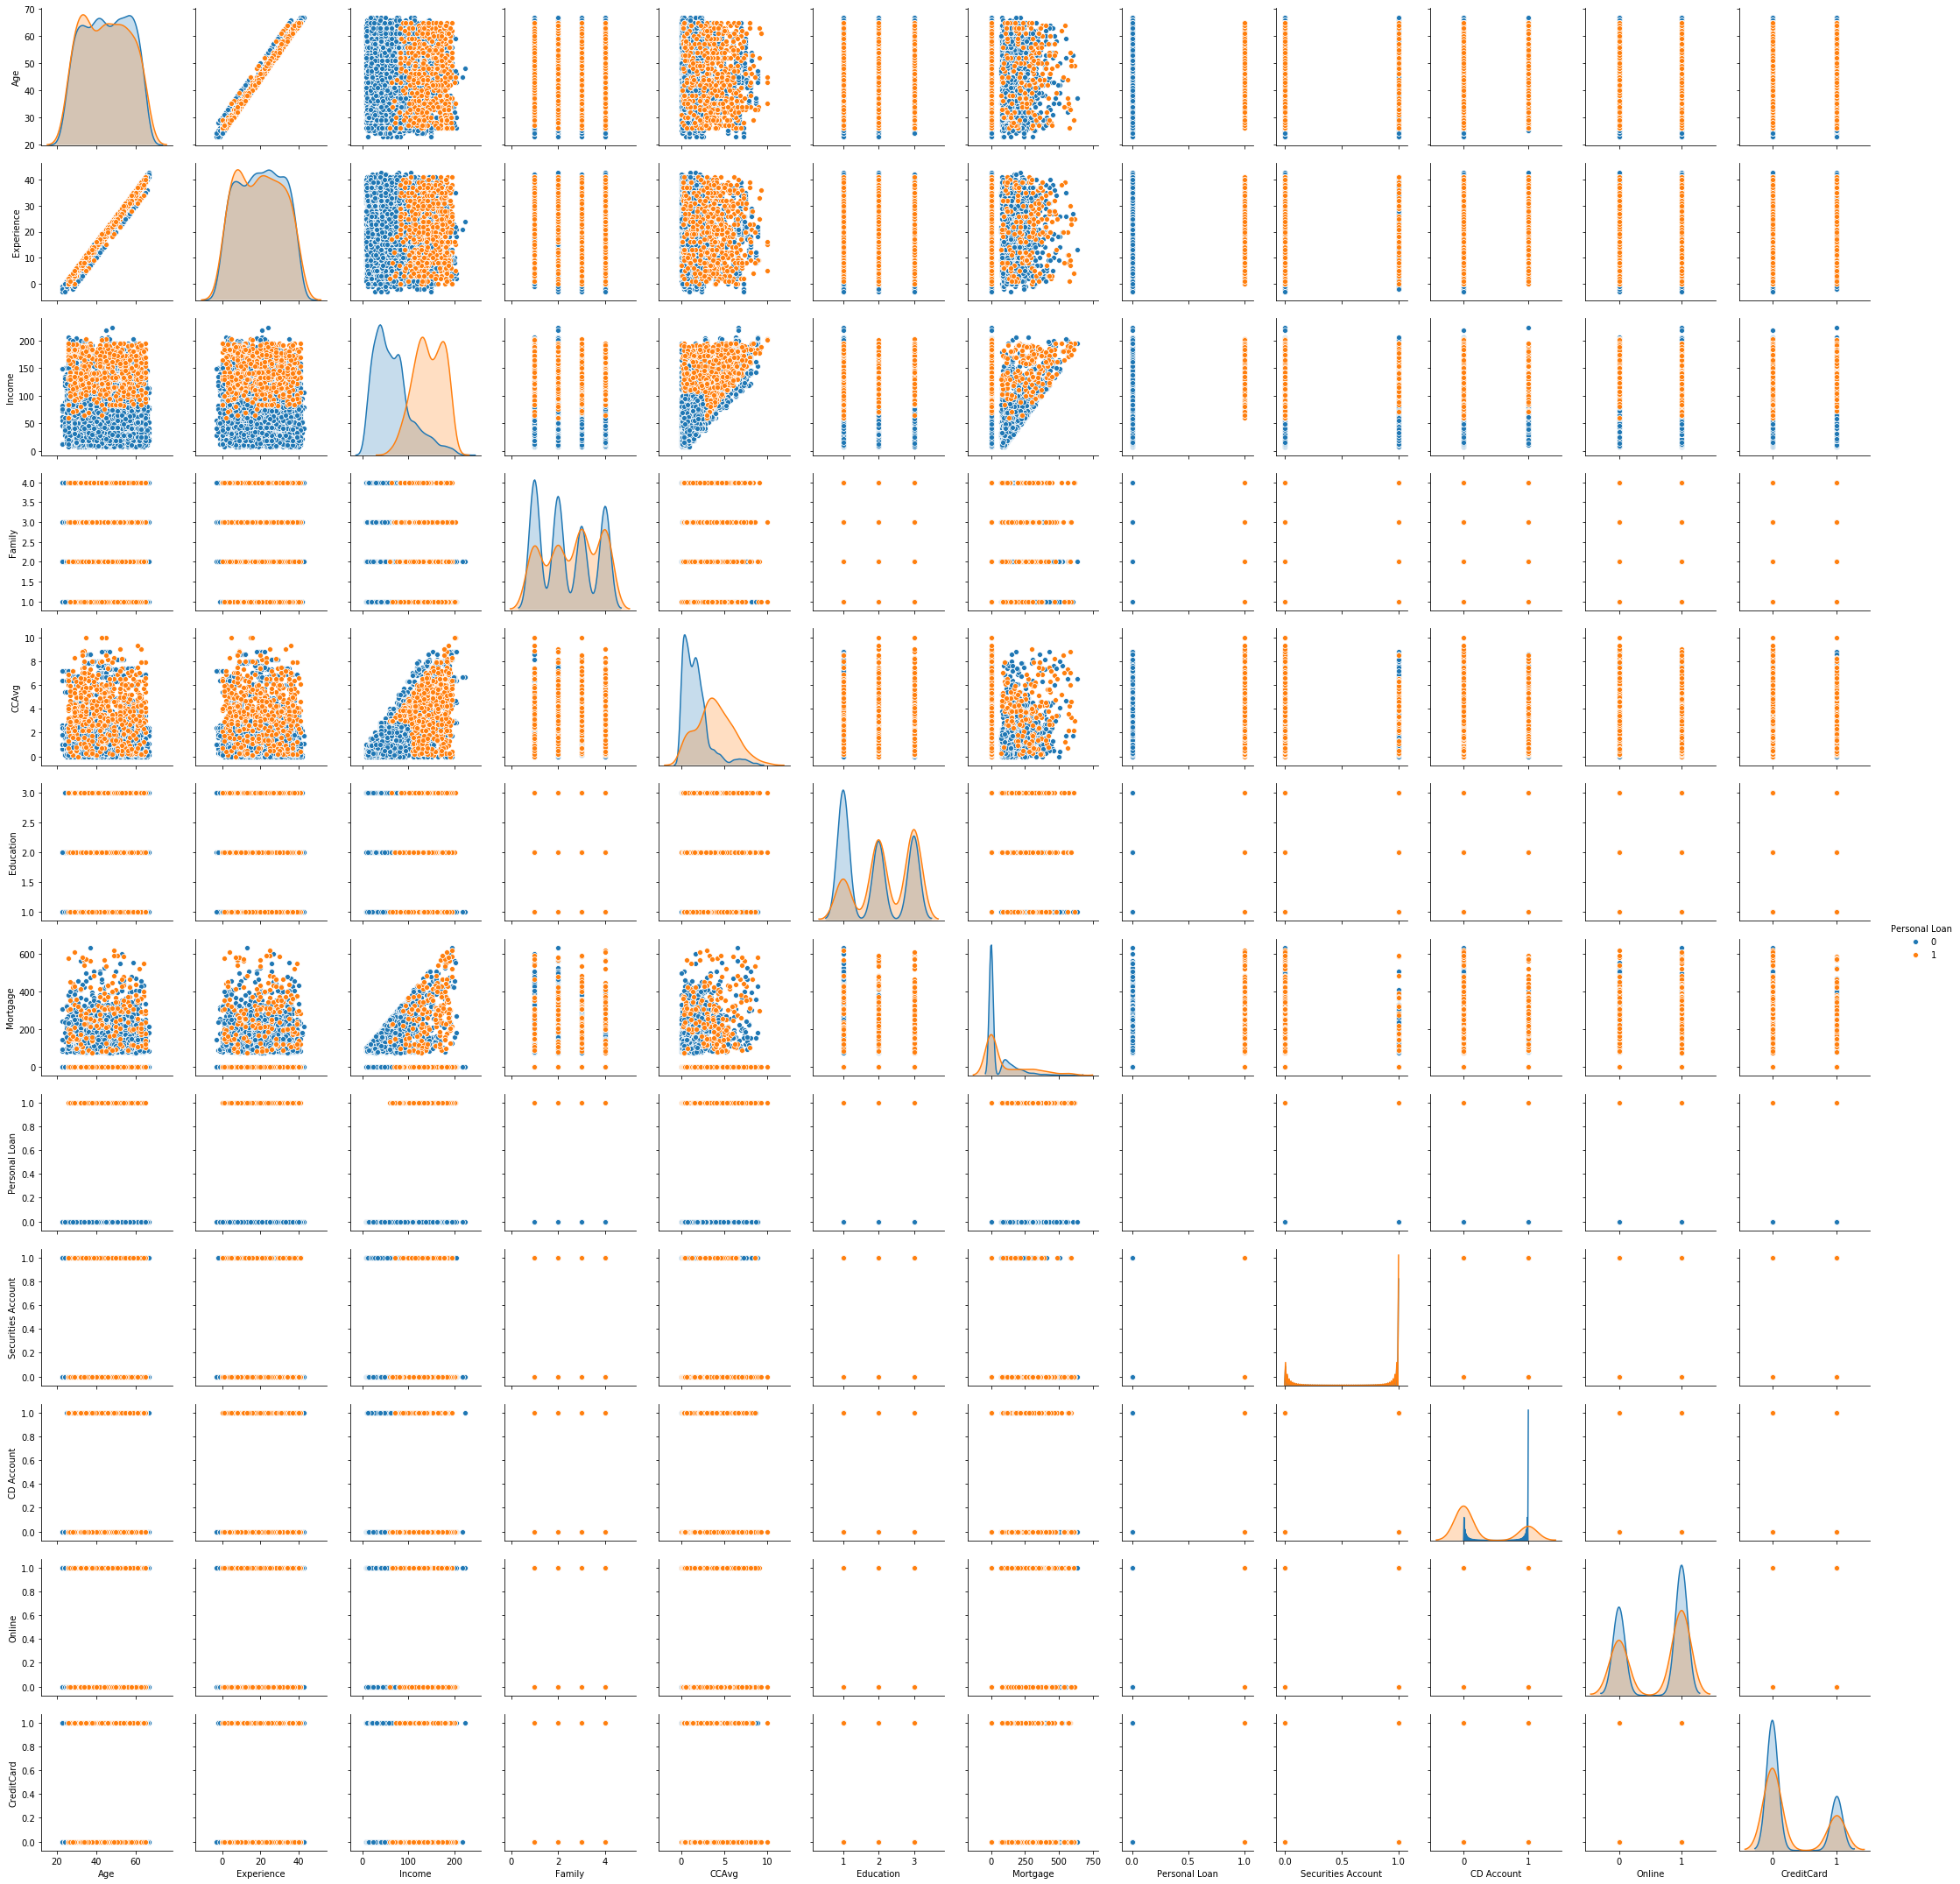

In [16]:
sns.pairplot(data, hue='Personal Loan')

# Обучение модели RandomForestClassifier

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Personal Loan'], axis=1),
    data['Personal Loan'],
    test_size=0.3,
    stratify=data['Personal Loan']
)

In [28]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [61]:
X_test_sm, y_test_sm = SMOTE(random_state=42).fit_resample(X_test, y_test)

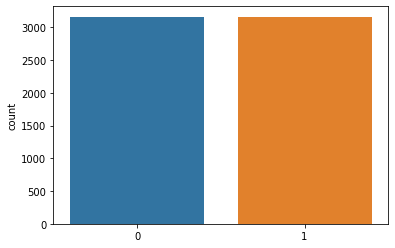

In [52]:
sns.countplot(x=y_res)

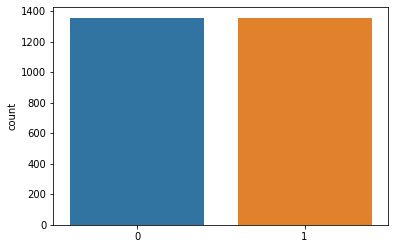

In [63]:
sns.countplot(x=y_test_sm)

In [53]:
tree_params = {
    'n_estimators': np.arange(100, 500, 50),
    'max_leaf_nodes': np.arange(10, 50, 5)
}

rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    tree_params,
    verbose=True,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

rf.fit(X_res, y_res)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  3.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'ma

# Качество получнной модели и важность признаков

In [64]:
sf.quality_report(rf.predict(X_res), y_res)

Accuracy: 0.996
Precision: 0.996
Recall: 0.996
f1_score: 0.996


In [65]:
sf.quality_report(rf.predict(X_test), y_test)

Accuracy: 0.982
Precision: 0.903
Recall: 0.909
f1_score: 0.906


/home/tay/ml-2019-08/12/secondary_fyncions.py:39: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  featureImportance["importance"].plot('bar');


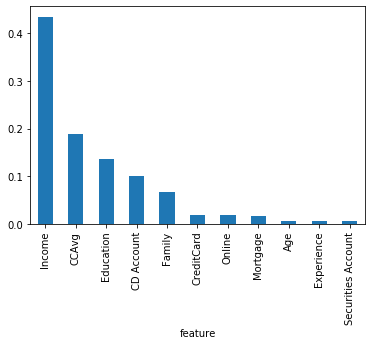

In [66]:
sf.plot_tree_feature_importance(rf, X_test.columns)

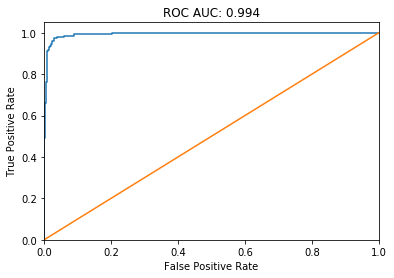

In [67]:
sf.plot_roc_curve(rf.predict_proba(X_test)[:,1], y_test)

# Градиентный Бустинг от sklearm

In [68]:
gbc = GradientBoostingClassifier()
gbc.fit(X_res, y_res)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [69]:
sf.quality_report(gbc.predict(X_test_sm), y_test_sm)

Accuracy: 0.985
Precision: 0.979
Recall: 0.991
f1_score: 0.985


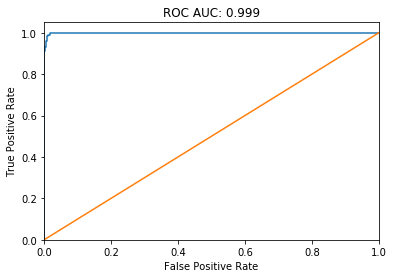

In [70]:
sf.plot_roc_curve(gbc.predict_proba(X_test_sm)[:,1], y_test_sm)

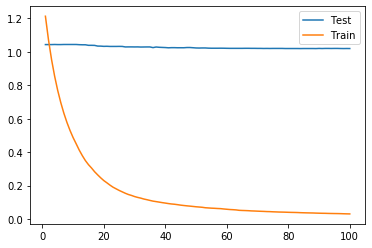

In [81]:
plot_loss(gbc, X_test_sm, y_test_sm)

# Сравнение скорости реализации от sklearn, lightgbm, xgboost

In [102]:
xgb_params1 = {
    'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1, 
    'silent': 1, 'objective': 'binary:logistic', 'nthread': 1
}
sklearn_params= {
    'n_estimators': 100, 'max_depth': 3
}

lightgbm_params = {
    'max_depth': 3,
    'n_estimators': 100,
    'num_threads': 1
}

xgb_time1 = list()
sklearn_time = list()
lightgbm_time = list()

n_runs = 20

for i in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Personal Loan'], axis=1),
    data['Personal Loan'],
    test_size=0.3,
    stratify=data['Personal Loan']
)
    X, y = SMOTE(random_state=42).fit_resample(X_train, y_train)

    t = time.time()
    bst = xgb.train(xgb_params1, xgb.DMatrix(X, label=y), 
                    num_boost_round=100)
    elapsed = time.time() - t
    xgb_time1.append(elapsed)

    t = time.time()
    clf = GradientBoostingClassifier(**sklearn_params).fit(X, y)
    elapsed = time.time() - t
    sklearn_time.append(elapsed)
    
    t = time.time()
    lgb_clf = lgb.LGBMClassifier(**lightgbm_params).fit(X, y)
    elapsed = time.time() - t
    lightgbm_time.append(elapsed)

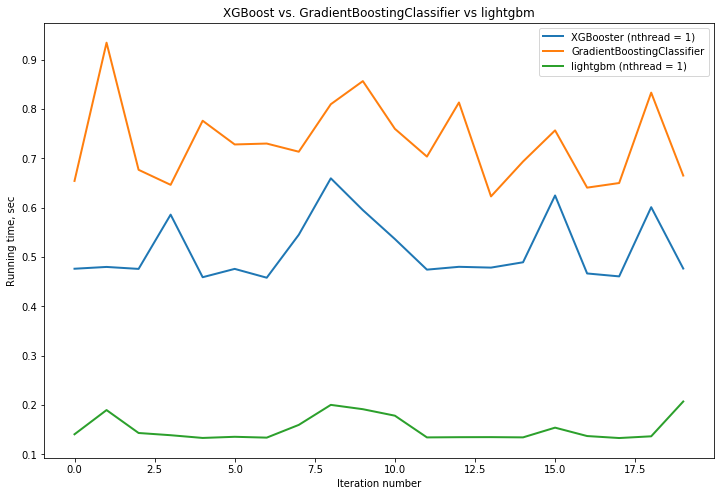

In [104]:

xgb_mean1 = sum(xgb_time1) / n_runs
sklearn_mean = sum(sklearn_time) / n_runs
lightgbm_mean = sum(lightgbm_time) / n_runs

plt.figure(figsize=(12, 8))
plt.plot(xgb_time1, label='XGBooster (nthread = 1)', lw=2)
plt.plot(sklearn_time, label='GradientBoostingClassifier', lw=2)
plt.plot(lightgbm_time, label='lightgbm (nthread = 1)', lw=2)
plt.legend(loc='best')
plt.xlabel('Iteration number')
plt.ylabel('Running time, sec')
plt.title('XGBoost vs. GradientBoostingClassifier vs lightgbm')
plt.show()